# Outlook #


In this colab, we will study basic linear and non-linear regression algorithms. Regression is another name for function approximation, it consists in fitting a function to a set of points, as shown below.


The colab is meant to study elements presented in lessons available in video here
https://www.youtube.com/playlist?list=PLe5mY-Da-ksURGcelU-egwtWZXxVgZ76a

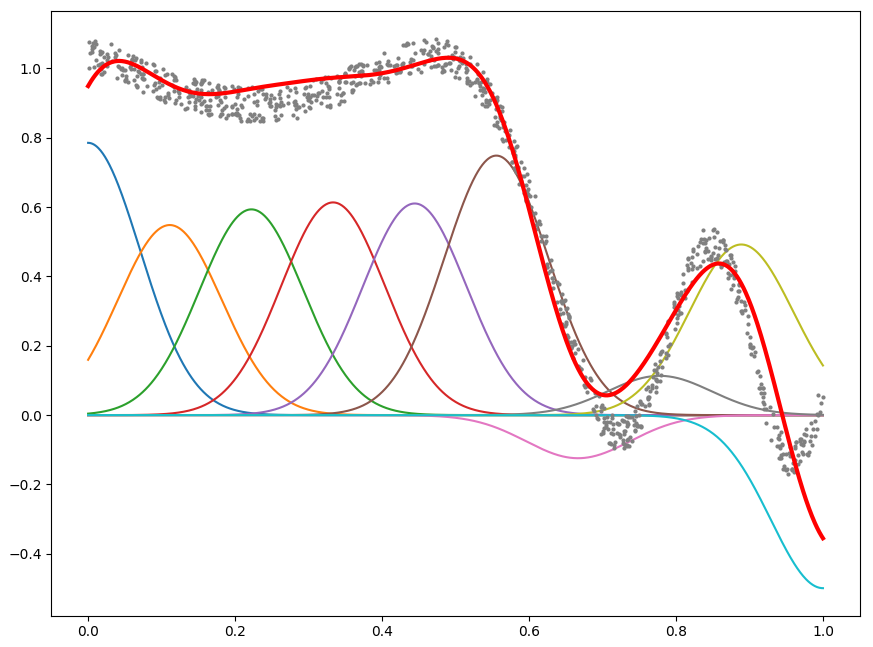

## Introduction ##

The objective of regression or function approximation is to create a model from observed data.
The model has a fixed structure with parameters (like the coefficients of a polynomial for instance),  and regression consists in adjusting these parameters to fit the data. In machine learning, it is a very important technique since having a good model enables better predictions and performance.

Generally speaking, given some data $\{ ({\bf x}^{(i)}, {\bf y}^{(i)}) \}$, the goal is to adjust a model ${\bf y} = f({\bf x})$ so that the *learned* function $f$ accounts for datapoints and generalize well to other unseen points. 

The simplest case is linear regression, which assumes a relation of type ${\bf y} = {\bf A}{\bf x} + {\bf b}$ between the data ${\bf x}$ and ${\bf y}$.

Several methods exist to adjust the parameters ${\bf A}$ and ${\bf b}$, the most well-known being the least squares method (or least norm in the multivariate case).

In this lab, we assume that ${\bf y}$ is of dimension 1 (and write $y$ instead of ${\bf y}$ in what follows). This is a very common assumption.

Furthermore, in the code ${\bf x}$ is also of dimension 1, this is more restrictive as regression is often used from multidimensional input data.


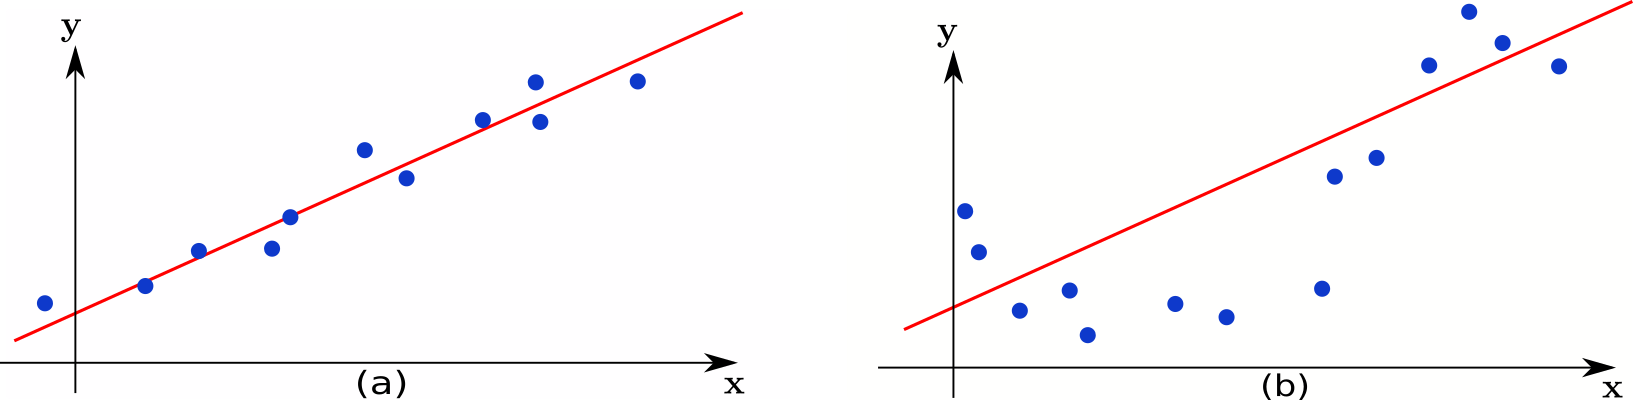

Often, linear models are not enough (see figures (a) and (b) above, on the left a linear regression is OK, but on the right it is not) and we must rely on nonlinear models.
Here, we focus on the case where $f$ can be written as a sum of $k$ functions parametrized by vectors ${\boldsymbol{\theta}}_i$:
$$
f({\bf x})  = \sum_{i=1}^k f_{\boldsymbol{\theta}_i}({\bf x}).
$$

In particular, we will use Gaussian functions.


### Weighted sums of Gaussian functions ###

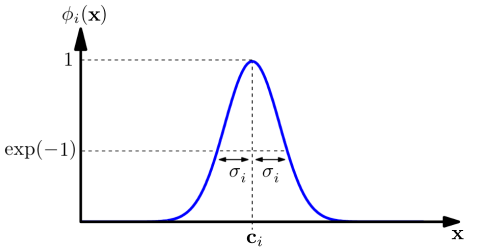


Gaussian functions $\phi_i({\bf x}) = \exp(-\frac{({\bf x}-{\bf c_i})^2}{\sigma_i^2})$ are almost equal to zero everywhere except in a neighborhood of ${\bf c_i}$, which represents the "center"' of the Gaussian (see above). The value of $\sigma_i$ determines how large this neighborhood is.

Then weighted Gaussian functions $f_{\boldsymbol{\theta}_i}$ can be written: 

$$
f_{\boldsymbol{\theta}_i} = {\bf \theta}_i \phi_i({\bf x}) = {\bf \theta}_i \exp\left(-\frac{({\bf x}-{\bf c_i})^2}{\sigma_i^2}\right).
$$

In these labs, the centers of the Gaussian functions are fixed in advance, and evenly distributed in the input space.
Besides, all the $\sigma_i$'s are usually set to the same value. Thus weighted Gaussian functions $f_{\boldsymbol{\theta}_i}$ have a unique scalar parameter which is their weight $\boldsymbol{\theta}_i$.

# Provided code and documentation #


The numpy reference guide is here: http://docs.scipy.org/doc/numpy/reference/


We provide a few useful classes and the infrastructure to perform these labs.

## Data generation ##

Two functions to generate points corresponding to a noisy linear and a noisy nonlinear model are provided in the *SampleGenerator* class in the *sample_generator.py* file.

## Batch of data ##

The *batch.py* file contains the *Batch* class. This class is used to collect a batch of linear or non-linear data, either in a single batch or incrementally.

## Vectors of Gaussian functions ##

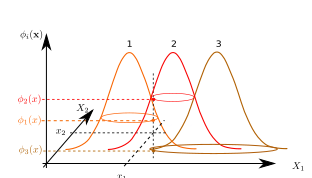


A class *Gaussians* is provided in *gaussians.py* to represent a vector of Gaussian feature functions $\phi({\bf x})$ of an input vector ${\bf x}$, as used in RBFNs and Locally Weighted Regression (LWR) (see below). The number of elements of $\phi({\bf x})$ (i.e. the number $k$ of Gaussian functions) is defined by the *nb_features* attribute. 

Given some input vector ${\bf x}$, the function *phi_output(x)* returns the vector of the output of (non-weighted) Gaussian functions applied to ${\bf x}$.
In the particular case where $x$ is a scalar, it is transformed into a one element vector to keep consistent with the N-dimensional case.

Note that the input of the (multivariate) Gaussian functions is of the same dimension as ${\bf x}$, but their output is one-dimensional (see the figure above).

## Function approximators ##


We consider three families of approximation models: linear models , radial basis function networks and locally weigthed regression models. In all these models, the *theta* attribute represents the vector of parameters to be optimized. The *f(self, x)* function represents the function approximator output for a given input *x*, to be optimized. The parameters used by $f$ is the *theta* attribute.


For instance, for RBFNs, we consider a vector of $k$ Gaussian functions $\phi({\bf x}) = (\phi_1({\bf x}) \ \phi_2({\bf x}) \cdots \phi_k({\bf x}))^\intercal$, a vector of weights $\boldsymbol{\theta} = (\boldsymbol{\theta}_1 \ \boldsymbol{\theta}_2 \cdots \boldsymbol{\theta}_k)^\intercal$, and a vector of weighted Gaussian functions $f({\bf x}) = \phi({\bf x})^\intercal \boldsymbol{\theta}$.

These function approximation models come with various *train_...(self, ...)* functions that must be filled.


## Visualization ##

For all the regression methods described below, as illustrated in the figure at the top of this colab, after executing it, the observed data are shown by points, and the red curve is the *learned* function $f$ corresponding to the parameters $\boldsymbol{\theta}$ that have been incrementally adjusted. When this applies, the other curves correspond to the $f_{\boldsymbol{\theta}_i}({\bf x})$ functions, they show the decomposition of $f$, which is the sum of all these functions. All visualization functions are in the *plot()* function of each approximator.

# Installation #

In [1]:
%pip install git+https://github.com/osigaud/regressionLabs

# (changement de !pip install par %pip install demandé par VSCode)
# permet d'installer les classes et méthodes décrites précédemment depuis le dépôt github

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/osigaud/regressionLabs to /tmp/pip-req-build-251y58i1
  Running command git clone --filter=blob:none --quiet https://github.com/osigaud/regressionLabs /tmp/pip-req-build-251y58i1
  Resolved https://github.com/osigaud/regressionLabs to commit 54e3fe51d4007bea8a9636684e87d19d0bc30b8b
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.


In [2]:
import time
import numpy as np
import matplotlib.pyplot as plt

from regression_labs.batch import Batch
from regression_labs.gaussians import Gaussians

# import des librairies et classes utiles

# Notations and code helpers


We consider either a batch regression approach or an incremental one. In the batch approach, we consider a batch of data consisting of $N$ $\{ ({\bf x}^{(i)}, y^{(i)}) \}_{1 \leq i \leq N}$ pairs.
In the incremental one, we get an additional pair of data $({\bf x}^{(t)}, y^{(t)})$ at each time step $t$.

In the general case, the input data ${\bf x}$ is of dimension $d$, and we have ${\bf x} = (x_1 \ x_2 \cdots x_d)^\intercal$.
Under algebraic form, the batch of data is rewritten $({\bf X}, {\bf y})$ where ${\bf X}$ is a $N \times d$ matrix and ${\bf y}$ is a $N$ dimensional vector.


## Issues with transpose() in numpy


In regression algorithms, we often use the transpose operator. But in *numpy*, transposing a standard one-dimensional vector does not work as expected: the result of the tranpose operator is the same vector.

Below we define two functions to fix this issue.

In [3]:
import numpy as np

def horiz_to_verti(vec):
  return np.atleast_2d(vec).transpose()

#Need to take the first element
def verti_to_horiz(vec):
  return vec.transpose()[0]

And here is a small example about how to use it.

In [4]:
vec = np.zeros(3)
print(vec)
v2 = vec.transpose()
print ("incorrect transpose:", v2)
v3 = horiz_to_verti(vec)
print ("correct transpose:", v3)
v4 = verti_to_horiz(v3)
print ("transpose of the transpose:", v4)

[0. 0. 0.]
incorrect transpose: [0. 0. 0.]
correct transpose: [[0.]
 [0.]
 [0.]]
transpose of the transpose: [0. 0. 0.]


## Augmenting the design matrix with one dimension


To solve a linear least square problem, we want to use a model of the form $f_{\boldsymbol{\theta}}({\bf X}) = {\bf X}\boldsymbol{\theta} + {\bf b}$.
To deal more elegantly with the intercept ${\bf b}$, we extend the vectors ${\bf x}$ with an additional dimension using $\bar{\bf x} = (x_1 \ x_2 \cdots x_d \ 1)^\intercal$,
and we redefine the augmented design matrix as
$$
\bar{\bf X}=\left(
\begin{array}{ccccc}
  {\bf x}_{1,1}&{\bf x}_{1,2}&\cdots &{\bf x}_{1,d} &1\\
  {\bf x}_{2,1}&{\bf x}_{2,2}&\cdots &{\bf x}_{2,d} &1\\
  \vdots  &\vdots  &\ddots &\vdots   &\vdots\\
  {\bf x}_{N,1}&{\bf x}_{N,2}&\cdots &{\bf x}_{N,d} &1\\
\end{array}
\right).
$$

From the list of vectors *x_data* provided by the sample generator, $\bar{\bf X}$ can be obtained by first transforming *x_data* into a *numpy array* and transposing using

```x_data = numpy.array(x_data).transpose()```,

and then adding the ones with:

```barX = np.hstack((x_data, numpy.ones((x_data.shape[0], 1))))```


Let us define the ```bar_design()``` function


In [5]:
def bar_design(x_data):
  x = np.array(x_data)
  xt = horiz_to_verti(x)
  return np.hstack((xt, np.ones((xt.shape[0], 1))))


And check that it works.

In [6]:
batch = Batch()
batch.make_linear_batch_data(5)
x_data = batch.x_data       # représenté horizontalement
print("input:", x_data)
barX = bar_design(x_data)
print("")
print ("Augmented design matrix:", barX)

input: [0.36839601634355246, 0.08575298996995451, 0.1422949190451912, 0.9234678250917994, 0.9656989063926917]

Augmented design matrix: [[0.36839602 1.        ]
 [0.08575299 1.        ]
 [0.14229492 1.        ]
 [0.92346783 1.        ]
 [0.96569891 1.        ]]


# Coding and study of regression algorithms #


We now investigate three basic regression algorithms: the Linear Least Squares (LLS), Radial Basis Function Networks (RBFNs) using various fitting algorithms, and Locally Weighted Regression (LWR). For each of these algorithms, there is a coding part where you have to code the main algorithms and check they work with a visualization, and a study part where you investigate their properties when changing some parameters or you perform comparisons. The study part may involve further coding to generate appropriate diagrams.


## Batch Linear Least squares ##


The linear least squares method finds the best linear model from a batch of data, using

$$
  \boldsymbol{\theta}^* = \min_{\boldsymbol{\theta}} \underbrace{\|{\bf y}-\bar{\bf X}\boldsymbol{\theta}\|^2}_{L(\boldsymbol{\theta})}.
$$

The parameters for the optimal model are given by:

$$
  \boldsymbol{\theta}^* = (\bar{\bf X}^\intercal\bar{\bf X})^{-1}{\bar{\bf X}}^\intercal{\bf y}.
$$

The code below provides the *Line* class. The way to get the linear least square model using *stats.linregress(x_data, y_data)* is given in the *train_from_stats(self, x_data, y_data)* function. In this provided function, **you just need to print the obtained values and set the *self.theta* attribute correctly**.


  Then, fill the ```train(self, x_data, y_data)``` function so as to perform the same linear least square computation using the above equation, **without** using ```stats.linregress(x_data, y_data)```.

In [7]:
from scipy import stats


class LinearModel:
    def __init__(self, batch_size):
        self.nb_dims = 1
        #We add one to add the offset in the end of the vector
        self.theta = np.zeros(self.nb_dims + 1)

    def f(self, x):
        """
        Get the FA output for a given input variable(s)

        :param x: A single or vector of dependent variables with size [Ns] for which to calculate the features

        :returns: the function approximator output
        """
        if np.size(x) == 1:
            xl = np.vstack(([x], [1]))
        else:
            xl = np.vstack((x, np.ones((1, np.size(x)))))
        return np.dot(self.theta, xl)

    # -- compute the residuals --#
    def compute_error(self, x_data, y_data):
      error = np.linalg.norm(y_data-self.f(x_data))
      return error

    # ----------------------#
    ## Training Algorithms ##
    # ----------------------#

    def train_from_stats(self, x_data, y_data):
        # Finds the Least Square optimal weights: python provided version
        slope, intercept, r_value, _, _ = stats.linregress(x_data, y_data)

        #print("slope :", slope)             # pente
        #print("intercept :", intercept)     # ordonnée à l'origine
        #print("r_value :", r_value)

        self.theta = [slope, intercept]

    def train(self, x_data, y_data):
        # Finds the Least Square optimal weights
        
        # Fill this part
        x_bar = bar_design(x_data)
        y_vertical = horiz_to_verti(y_data)

        # (renvoie une matrice verticale)
        self.theta = np.dot(np.linalg.inv( np.dot(np.transpose(x_bar),x_bar) ), np.dot(np.transpose(x_bar),y_vertical))
        # transposition pour rendre theta horizontale et utilisable par la methode f(.)
        self.theta = verti_to_horiz(self.theta)

    def train_regularized(self, x_data, y_data, coef):
        # Finds the regularized Least Square optimal weights

        # Fill this part
        x_bar = bar_design(x_data)
        y_vertical = horiz_to_verti(y_data)

        # (renvoie une matrice verticale)
        self.theta = np.dot(np.linalg.inv( coef*np.eye(np.shape(x_bar)[1]) + np.dot(np.transpose(x_bar),x_bar) ), np.dot(np.transpose(x_bar),y_vertical))
        # transposition pour rendre theta horizontale et utilisable par la methode f(.)
        self.theta = verti_to_horiz(self.theta)

    # -----------------#
    # # Plot function ##
    # -----------------#

    def plot(self, x_data, y_data):
        xs = np.linspace(0.0, 1.0, 1000)
        z = self.f(xs)

        plt.plot(x_data, y_data, 'o', markersize=3, color='lightgreen')
        plt.plot(xs, z, lw=2, color='red')
        plt.show()

Visualize whether your code works.
 

theta: [ 3.67406216 -3.60402789]
LLS time: 0.00826989499999975


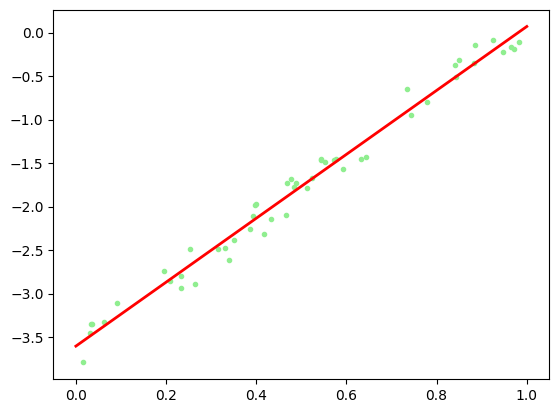

theta: [3.6740621641998352, -3.6040278903988567]
LLS from scipy stats time: 0.0031593949999999538


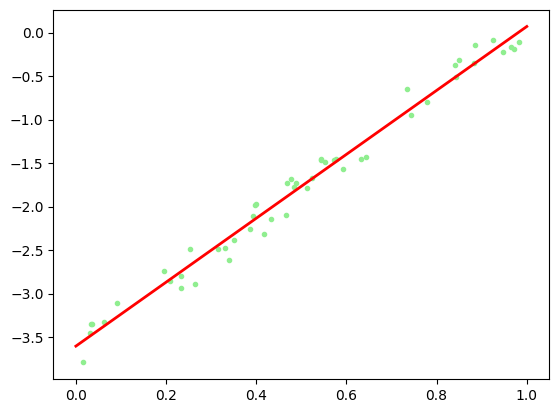

In [8]:
batch = Batch()
size = 50
batch.make_linear_batch_data(size)
model = LinearModel(size)
x = np.array(batch.x_data)
y = np.array(batch.y_data)

start = time.process_time()
model.train(x, y)
theta1 = model.theta
print("theta:", model.theta)
print("LLS time:", time.process_time() - start)
model.plot(x, y)

start = time.process_time()
model.train_from_stats(x, y)
theta2 = model.theta
print("theta:", model.theta)
print("LLS from scipy stats time:", time.process_time() - start)
model.plot(x, y)


### Study part ###

Does your ```train(self, x_data, y_data)``` function provide exactly the same results as the ```train_from_stats(self, x_data, y_data)``` function? Call both functions 2000 times. Is one faster than the other?

In [9]:
print("différences de theta : ", np.abs(theta1 - theta2))
# pas exactement le même résultat, probablement un écart du à des approximations dans les différentes méthodes
# cependant différence très faible de l'ordre de e^-15


time_lls = np.zeros(2000)
time_lls_stats = np.zeros(2000)

for i in range(2000):
    batch = Batch()
    size = 50
    batch.make_linear_batch_data(size)
    model = LinearModel(size)
    x = np.array(batch.x_data)
    y = np.array(batch.y_data)

    start = time.process_time()
    model.train(x, y)
    time_lls[i] = time.process_time() - start

    start = time.process_time()
    model.train_from_stats(x, y)
    time_lls_stats[i] = time.process_time() - start

print("moyenne de temps lls : ", np.mean(time_lls))
print("moyenne de temps lls avec stats : ", np.mean(time_lls_stats))
# on semble constater que l'utilisation de stats est plus rapide (~4e-4 seconde)
# après redémarrage et de nouveaux tests, les temps semblent en moyenne être quasiment identiques


différences de theta :  [3.55271368e-15 2.22044605e-15]
moyenne de temps lls :  0.0014955506419999742
moyenne de temps lls avec stats :  0.0013554241379999667


### Ridge Regression ###

In the *Line* class above, fill the *train_regularized(self, x_data, y_data, coef)* function.

And check that it works with a new batch of data

theta regularized: [ 0.60449998 -0.14672456]
regularized LLS : 0.002990724


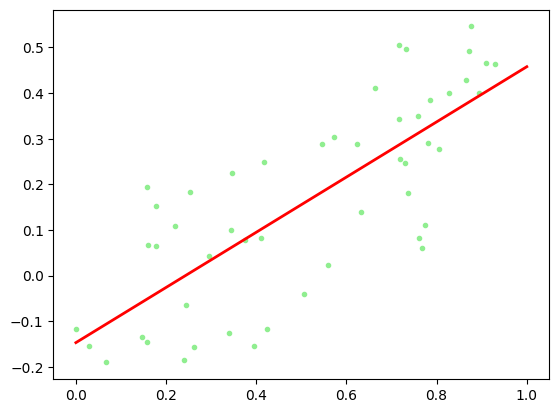

In [12]:
batch = Batch()
size = 50
batch.make_linear_batch_data(size)
model = LinearModel(size)

start = time.process_time()
model.train_regularized(batch.x_data, batch.y_data, coef=0.01)
print("theta regularized:", model.theta)
print("regularized LLS :", time.process_time() - start)
model.plot(batch.x_data, batch.y_data)


### Study part

**For a batch of 50 points, study with the *train_regularized(self,x_data,y_data,coef)* function how the residuals degrade as you increase the value of coef.** A good idea would be to make a picture with coef in the x axis and the residuals in the y axis, and then to comment it.

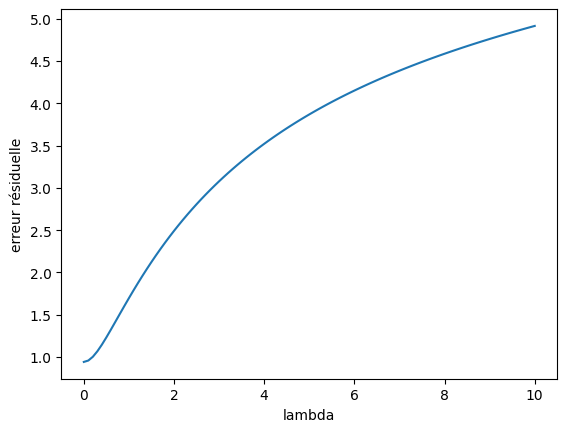

In [13]:
batch = Batch()
size = 50
batch.make_linear_batch_data(size)
model = LinearModel(size)

lmbda = np.linspace(0,10,101)
error = np.zeros(101)

for i in range(101):
    model.train_regularized(batch.x_data, batch.y_data, coef=lmbda[i])
    error[i] = model.compute_error(batch.x_data,batch.y_data)

plt.plot(lmbda, error)
plt.xlabel("lambda")
plt.ylabel("erreur résiduelle")
plt.show()
# l'erreur résiduelle semble pourtant croissante avec le coefficient ?

# Radial Basis Function Networks #


Let us now study Radial Basis Function Networks (RBFNs). We will implement several regression techniques with these models: batch least squares, gradient descent, and recursive least squares. We first define a general purpose ```RBFN``` class that encode the vector of parameters ${\bf \theta}$, the function ${\bf \phi(x)}$, a function to compute the error of a model and a plot function.

In [14]:
class RBFN(Gaussians):
    def __init__(self, nb_features):
        super().__init__(nb_features)
        self.theta = np.zeros(self.nb_features)

    def f(self, x):
        """
        Get the FA output for a given input vector
    
        :param x: A vector of dependent variables of size N
        :If left blank the method will default to using the trained thetas in self.theta.
        
        :returns: A vector of function approximator outputs with size nb_features -> /!\ size N ?
        """

        value = np.dot(self.phi_output(x).transpose(), self.theta)
        # (np.dot passe automatiquement theta en vect colonne ou vect ligne selon les besoins
        # à respecter pour rendre possible la multiplication matricielle)
        return value

    def feature(self, x, idx):
        """
         Get the output of the idx^th feature for a given input vector
         This is function f() considering only one feature
         Used mainly for plotting the features

         :param x: A vector of dependent variables of size N
         :param idx: index of the feature

         :returns: the value of the feature for x
         """
        phi = self.phi_output(x)
        return phi[idx] * self.theta[idx]


    # -- compute the residuals --#
    def compute_error(self, x_data, y_data):
      error = np.linalg.norm(y_data-self.f(x_data))
      return error

    # ------ Plot function -------#
    def plot(self, x_data, y_data):
        xs = np.linspace(0.0, 1.0, 1000)
        z = []
        for i in xs:
            z.append(self.f(i))

        z2 = []
        for i in range(self.nb_features):
            temp = []
            for j in xs:
                temp.append(self.feature(j, i))
            z2.append(temp)

        plt.plot(x_data, y_data, 'o', markersize=3, color='lightgreen')
        plt.plot(xs, z, lw=3, color='red')
        for i in range(self.nb_features):
            plt.plot(xs, z2[i])
        plt.show()


## Batch RBFNs ##

When applied to RBFNs, there are two perspectives about the batch least squares method.



### First perspective ###


The **first perspective** consists in considering that the RBFN is used to project from an input space into a feature space, before performing the standard linear least square calculation in this projected space.

Thus, from the batch of data we build the Gram matrix ${\bf G}$, projecting each datapoint $x^{(i)}_{1 \leq i \leq N}$ into its output vector for all the features $\phi_j({\bf x}^{(i)})_{1 \leq j \leq k}$. Then we apply the standard linear least square method, replacing the augmented design matrix $\bar{\bf X}$ with the Gram matrix ${\bf G}$:

$$
  \boldsymbol{\theta}^* = ({\bf G}^\intercal{\bf G})^{-1}{{\bf G}}^\intercal{\bf y}.
$$
This is the easiest approach to code in python.

In the code of the ```BatchRBFN1``` class below, fill the ```train_ls(self, x_data, y_data)``` function.

In [15]:
class BatchRBFN1(RBFN):
    def __init__(self, nb_features):
        super().__init__(nb_features)

    # ------ batch least squares first perspective) ---------
    def train(self, x_data, y_data):
        
        # Fill this part
        # /!\ phi_output renvoie une matrice de taille (nb_feature x N)
        gram = np.transpose(self.phi_output(x_data))
        y_vertical = horiz_to_verti(y_data)

        # (renvoie une matrice verticale)
        self.theta = np.dot(np.linalg.inv( np.dot(np.transpose(gram),gram) ), np.dot(np.transpose(gram),y_vertical))
        # transposition pour rendre theta horizontale et utilisable par la methode d'affichage
        self.theta = verti_to_horiz(self.theta)

### Second perspective ###

In the **second perspective**, we perform the whole calculation from scratch. We want to minimize the following error:
$$
\epsilon(\boldsymbol{\theta}) = \frac{1}{2N}\sum_{i=1}^N (y^{(i)} - f_{\boldsymbol{\theta}}({\bf x}^{(i)}))^2.
$$

To get a local minimum over $\boldsymbol{\theta}$ of the function $\epsilon(\boldsymbol{\theta})$, we need to solve $\nabla_{\boldsymbol{\theta}} \epsilon(\boldsymbol{\theta}) = {\bf 0}$.
To compute the gradient, we use $\nabla (g^2) = 2g\nabla g$.
Therefore, we have

$$\nabla_{\boldsymbol{\theta}} \epsilon(\boldsymbol{\theta}) = \frac{1}{N}\sum_{i=1}^N  \left(y^{(i)} - f_{\boldsymbol{\theta}}\big( {\bf x}^{(i)}\big)\right)\nabla_{\boldsymbol{\theta}} f_{\boldsymbol{\theta}}({\bf x}^{(i)}).$$

Since $f_{\boldsymbol{\theta}}({\bf x}) = \phi({\bf x})^\intercal \boldsymbol{\theta}$, we have $\nabla_{\boldsymbol{\theta}} f_{\boldsymbol{\theta}}({\bf x}^{(i)}) = \phi({\bf x}^{(i)})$ and we get

$$\nabla_{\boldsymbol{\theta}} \epsilon(\boldsymbol{\theta}) = \frac{1}{N}\sum_{i=1}^N  \left(y^{(i)} - \phi({\bf x}^{(i)})^\intercal \boldsymbol{\theta}\right)\phi({\bf x}^{(i)})$$

To make the gradient $\nabla_{\boldsymbol{\theta}} \epsilon(\boldsymbol{\theta}) = {\bf 0}$, we get:

$$\frac{1}{N}\sum_{i=1}^N \left(y^{(i)} - \phi({\bf x}^{(i)})^\intercal \boldsymbol{\theta}\right)\phi({\bf x}^{(i)}) = 0$$

$$\frac{1}{N}\sum_{i=1}^N \left(\phi({\bf x}^{(i)})y^{(i)} - \phi({\bf x}^{(i)}) \phi({\bf x}^{(i)})^\intercal \boldsymbol{\theta}\right) = 0$$

$$\left( \sum_{i=1}^N \phi({\bf x}^{(i)}) \phi({\bf x}^{(i)})^\intercal \right) \boldsymbol{\theta} = \sum_{i=1}^N \phi({\bf x}^{(i)}) y^{(i)}.$$

Let us set

$${\bf A} = \left( \sum_{i=1}^N \phi({\bf x}^{(i)}) \phi({\bf x}^{(i)})^\intercal \right)$$

and 

$${\bf b} = \sum_{i=1}^N \phi({\bf x}^{(i)}) y^{(i)}.$$

We then have ${\bf A} \boldsymbol{\theta} = {\bf b}$.
${\bf A}$ is not necessarily an invertible matrix, and the general solution is obtained as $\boldsymbol{\theta} = A^\sharp b$, by using either the ``pseudo-inverse'' $A^\sharp$ ```(np.linalg.pinv(A))``` or using ```theta = np.linalg.solve(A,b)```.



In the code of the ```BatchRBFN2``` class below, fill the code of the ```train(self, x_data, y_data)``` function according to the above perspective.

In [16]:
class BatchRBFN2(RBFN):
    def __init__(self, nb_features):
        super().__init__(nb_features)

    # ------ batch least squares (second perspective) ---------
    def train(self, x_data, y_data):
        
        # Fill this part
        y_vertical = horiz_to_verti(y_data)

        A = np.dot( self.phi_output(x_data), np.transpose(self.phi_output(x_data)) )    # dimension : nb feature * nb feature
        b = np.dot(self.phi_output(x_data), y_vertical)     # dimension : nb feature

        self.theta = np.linalg.solve(A,b)
        self.theta = verti_to_horiz(self.theta)

Now, run the code below to see if yours works.

theta ls1 : [ 0.30023894  0.10790647  0.12209162  0.14986016  0.44699726 -0.15927796
 -0.48984346 -0.07699647 -0.31653922 -0.45556598]
error :  0.9630044707379198
RBFN LS time: 0.007448988000078316


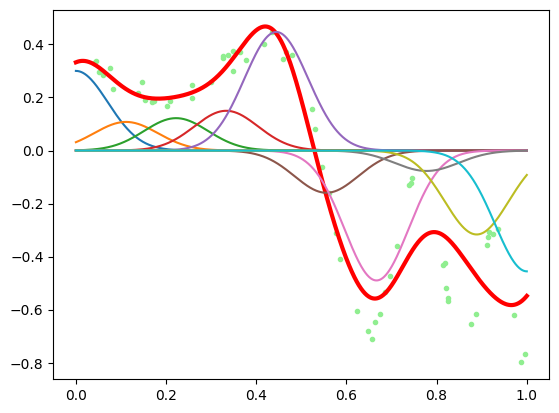

theta ls2 : [ 0.30023894  0.10790647  0.12209162  0.14986016  0.44699726 -0.15927796
 -0.48984346 -0.07699647 -0.31653922 -0.45556598]
error :  0.9630044707379198
RBFN LS2 time: 0.005647800000019743


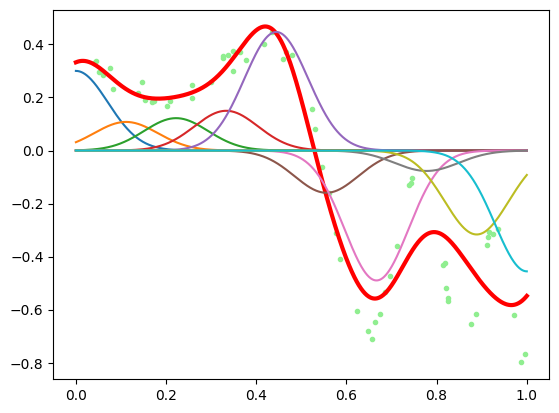

In [38]:
batch = Batch()
batch.make_nonlinear_batch_data(size=60)
model = BatchRBFN1(nb_features=10)      # /?\ comment on définit ce nb, au hasard?

start = time.process_time()
model.train(batch.x_data, batch.y_data)
error = model.compute_error(batch.x_data, batch.y_data)
print("theta ls1 :", model.theta)
print("error : ", error)
print("RBFN LS time:", time.process_time() - start)
model.plot(batch.x_data, batch.y_data)

model = BatchRBFN2(nb_features=10)
start = time.process_time()
model.train(batch.x_data, batch.y_data)
error = model.compute_error(batch.x_data, batch.y_data)
print("theta ls2 :", model.theta)
print("error : ", error)
print("RBFN LS2 time:", time.process_time() - start)
model.plot(batch.x_data, batch.y_data)


### Study part

Calling the ```train``` functions at least 1000 times, comment on the difference in computation time between the first and the second perspective.

In [19]:
time_RBFN1 = np.zeros(2000)
time_RBFN2 = np.zeros(2000)

for i in range(2000):
    batch = Batch()
    batch.make_nonlinear_batch_data(size=60)
    model1 = BatchRBFN1(nb_features=10)
    model2 = BatchRBFN2(nb_features=10)
    x = np.array(batch.x_data)
    y = np.array(batch.y_data)

    start = time.process_time()
    model1.train(x, y)
    time_RBFN1[i] = time.process_time() - start

    start = time.process_time()
    model2.train(x, y)
    time_RBFN2[i] = time.process_time() - start

print("moyenne de temps RBNF1 : ", np.mean(time_RBFN1))
print("moyenne de temps RBNF2 : ", np.mean(time_RBFN2))
# RBNF1 sensiblment plus long que RBNF2 ?

moyenne de temps RBNF1 :  0.002003741613000013
moyenne de temps RBNF2 :  0.001839408650499971


**Study the evolution of the error as a function of the number of features**. A good idea would be to make a picture with the number of features in the x axis and the residuals in the y axis, and then to comment it. Have a look at the model when the number of features is large (e.g. 30). What is happening?

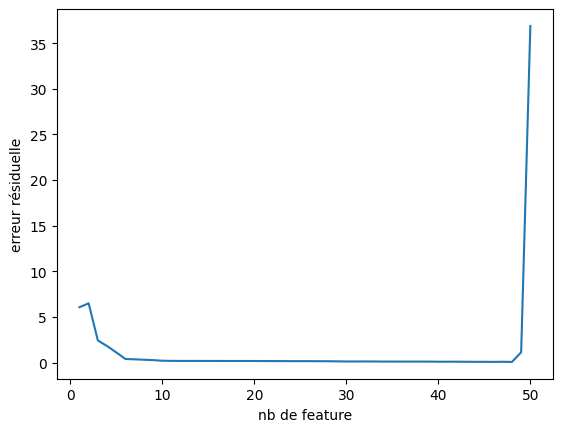

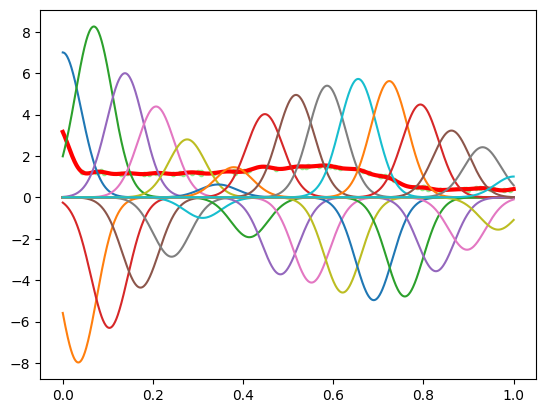

In [39]:
batch = Batch()
batch.make_nonlinear_batch_data(size=60)

feature = np.linspace(1,50,50)
error = np.zeros(50)

for i in range(50):
    model = BatchRBFN1(nb_features=int(feature[i]))
    model.train(batch.x_data, batch.y_data)
    error[i] = model.compute_error(batch.x_data,batch.y_data)

plt.plot(feature, error)
plt.xlabel("nb de feature")
plt.ylabel("erreur résiduelle")
plt.show()
# l'écart résiduel décroît progressivement plus on augmente le nombre de features,
# cependant sur certains tests, l'écart remonte fortement autour de 50

model = BatchRBFN1(nb_features=30)
model.train(batch.x_data, batch.y_data)
model.plot(batch.x_data,batch.y_data)
# on peut constater un overfitting du model sur les données de tests,
# la courbe formée suit de près les moindres bosses et creux des points

## Incremental RBFNs ##

For this part we define a general purpose ```IncrRBFN``` class that we derive below in different subclasses to implement the various algorithms.

In [21]:
class IncrRBFN(RBFN):
    def __init__(self, nb_features):
        super().__init__(nb_features)
        self.theta = np.random.random(self.nb_features)

    def f(self, x, theta=None):
        """
        Get the FA output for a given input vector
    
        :param x: A vector of dependent variables of size N
        :param theta: A vector of coefficients to apply to the features. 
        :If left blank the method will default to using the trained thetas in self.theta.
        
        :returns: A vector of function approximator outputs with size nb_features -> /!\ size N ?
        """
        if not hasattr(theta, "__len__"):
            theta = self.theta
        value = np.dot(self.phi_output(x).transpose(), theta)
        return value

    # -------- this function will be redefined in subclasses -----------------
    def train(self, x, y, alpha):
        raise NotImplementedError

### Gradient Descent ###


Let the vector $\boldsymbol{\theta}^{(t)}$ be the value of the parameters of the regression model at iteration $t$. 
We observe some new data $({\bf x}^{(t+1)}, y^{(t+1)})$.
The error of the current model on this pair is
$$
\epsilon^{(t+1)} = y^{(t+1)} - f_{\boldsymbol{\theta}}( {\bf x}^{(t+1)}).
$$

The idea of gradient descent is to slightly modify $\boldsymbol{\theta}$ 
to decrease $\epsilon^{(t+1)}$.
To do so, we consider the function $\boldsymbol{\theta} \mapsto y^{(t+1)} - f_{\boldsymbol{\theta}}\left( {\bf x}^{(t+1)}\right)$
and compute its gradient in $\boldsymbol{\theta}^{(t+1)}$, which we denote by $\nabla_{\boldsymbol{\theta}^{(t+1)}}$.
Since we have $f_{\boldsymbol{\theta}}({\bf x}) = \phi({\bf x})^\intercal \boldsymbol{\theta}$, we get $\nabla_{\boldsymbol{\theta}^{(t+1)}} = - \phi({\bf x}^{(t+1)})$.

The gradient of a function is oriented towards the direction of steepest increase. This means that it gives the direction in which a small modification of the vector of inputs leads to the largest increase of the function output. The opposite direction is the one of steepest decrease.

Here, the goal is to decrease $\epsilon^{(t+1)}$ thus $\boldsymbol{\theta}^{(t+1)}$ should be modified in the direction defined by $- \nabla_{\boldsymbol{\theta}}^{(t+1)} =  \phi({\bf x}^{(t+1)})$.
The resulting update formula is

\begin{align*}
  \boldsymbol{\theta}^{(t+1)} &= \boldsymbol{\theta}^{(t)} + \alpha \epsilon^{(t+1)} \nabla_{\boldsymbol{\theta}}^{(t+1)} \\
  &= \boldsymbol{\theta}^{(t)} + \alpha (y^{(t+1)} - f_{\boldsymbol{\theta}}( {\bf x}^{(t+1)})) \phi({\bf x}^{(t+1)}) \\
\end{align*}

where $\alpha > 0$ is a coefficient called the ``learning rate''.

Using $f_{\boldsymbol{\theta}}({\bf x}) = \phi({\bf x})^\intercal \boldsymbol{\theta}$, we can also write it:
$$
\boldsymbol{\theta}^{(t+1)} = \boldsymbol{\theta}^{(t)} + \alpha (y^{(t+1)} - \phi({\bf x}^{(t+1)})^\intercal \boldsymbol{\theta}^{(t)}) \phi({\bf x}^{(t+1)}).
$$


### Relationship to training neural networks ###


The approach above is at the heart of machine learning techniques used to tune neural networks. The error $\epsilon^{(t+1)}$ is called the **loss function**. We have seen that we could slightly decrease this error for next time by descending the gradient of this loss with respect to the model parameters $\theta$. In neural networks libraries such as pytorch or tensorflow, we do the same: we compute a loss corresponding to the error made by the model on some data, and the library will perform gradient descent with respect to the parameters by computing the derivative for you.

**In the ```GDRBFN``` class below, fill the ```train(self, x, y, alpha)``` function**.

In [22]:
class GDRBFN(IncrRBFN):
    def __init__(self, nb_features):
        super().__init__(nb_features)

    
    # -------- gradient descent -----------------
    def train(self, x, y, alpha):

        # Fill this part
        self.theta += alpha * np.dot( y - np.dot( np.transpose(self.phi_output(x)), self.theta) , np.transpose(self.phi_output(x)) )


And check that it works

error :  0.9329945246591205
RBFN grad descent time: 0.16043606200000227


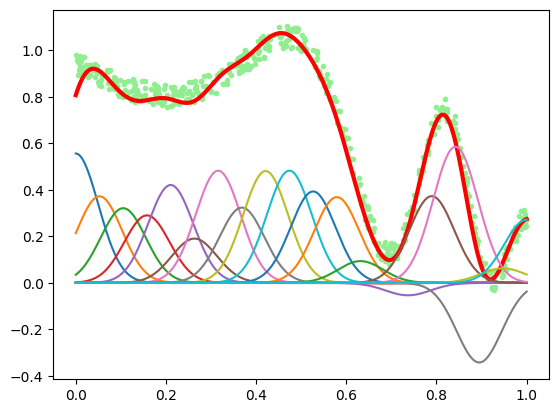

In [23]:
batch = Batch()
max_iter = 500
model = GDRBFN(nb_features=20)
start = time.process_time()

for i in range(max_iter):
    x, y = batch.add_non_linear_sample()
    model.train(x, y, alpha=0.5)

error = model.compute_error(batch.x_data, batch.y_data)
print("error : ", error)
print("RBFN grad descent time:", time.process_time() - start)
model.plot(batch.x_data, batch.y_data)


### Recursive Least Squares ###


Recursive Least Squares is the incremental version of the batch Least Squares method.
In this variant, ${\bf A}$ and ${\bf b}$ are recomputed everytime some new data pair is obtained, with the following equations: 

\begin{align*}
{\bf A}^{(t+1)} &= {\bf A}^{(t)} + \phi({\bf x}^{(t+1)}) \phi({\bf x}^{(t+1)})^\intercal,\\
{\bf b}^{(t+1)} &= {\bf b}^{(t)} + \phi({\bf x}^{(t+1)}) y^{(t+1)}.
\end{align*}

The parameters are then computed as $\boldsymbol{\theta}^{(t+1)} = ({\bf A}^{(t+1)})^\sharp b^{(t+1)}$. One may also use ```numpy.solve(A,b)``` as before, but this can fail when ${\bf A}$ is singular.

Another incremental approach avoids the computation of the pseudo-inverse $({\bf A}^{(t+1)})^\sharp$ by computing this inverse incrementally, using the Sherman-Morrison formula: 

\begin{align*}
  u = v^T &= \phi({\bf x}^{(t)}) \\
({\bf A}^{(t+1)})^\sharp &= {\bf A}^{(t)\sharp} - \frac{{\bf A}^{(t)\sharp} uv {\bf A}^{(t)\sharp}}{1 + v {\bf A}^{(t)\sharp} u},\\
{\bf b}^{(t+1)} &= {\bf b}^{(t)} + \phi({\bf x}^{(t)}).\\
\end{align*}
**Remark:** to apply this formula, we must start with a non-zero value for $A^{(0)\sharp}$, e.g. the Identity matrix.


**In the ```RLSRBFN``` class below, fill the code of the ```train(self, x, y)``` function.** The one with the Sherman-Morrisson approach is provided.

In [24]:
class RLSRBFN(IncrRBFN):
    def __init__(self, nb_features):
        super().__init__(nb_features)
        self.a = np.zeros(shape=(self.nb_features, self.nb_features))
        self.b = np.zeros(self.nb_features)
        self.a_inv = np.matrix(np.identity(self.nb_features))
    
    # -------- recursive least squares -----------------
    def train(self, x, y):
        
        # Fill this part
        y_vertical = horiz_to_verti(y)

        self.a += np.dot(self.phi_output(x), np.transpose(self.phi_output(x)))
        self.b += np.transpose( np.dot(self.phi_output(x), y_vertical) )[0]

        self.theta = np.dot(np.linalg.pinv(self.a), self.b)

    # -------- recursive least squares with Sherman-Morrison -----------------
    def train_rls_sherman_morrison(self, x, y):
        u = self.phi_output(x)
        v = self.phi_output(x).transpose()
        mat = v * self.a_inv * u

        value = mat[0, 0] + 1
        if value == 0:# It's not invertable
          return None
        coef = 1.0 / value

        prod = np.dot(u, v)

        tmp_mat = np.dot(self.a_inv, prod) 
        tmp_mat2 = np.dot(tmp_mat, self.a_inv)

        self.a_inv = self.a_inv - coef * tmp_mat2

        tmp_vec = y * verti_to_horiz(self.phi_output(x))
        self.b = self.b + tmp_vec

        # Very suprisingly, we get a [[1 2 3 4]] vec here instead of [1 2 3 4]
        result = np.dot(self.a_inv, self.b)
        # And even more surprisingly we have to write this so that it works
        self.theta = np.array(result)[0]

Finally, run them:

RLS theta [1.3425377  0.9621919  1.01451193 0.99834966 1.0044964  1.06171358
 0.19381411 0.20639519 0.75724014 0.08552727]
error :  4.603666657936577
RBFN RLS time: 4.819629376999998


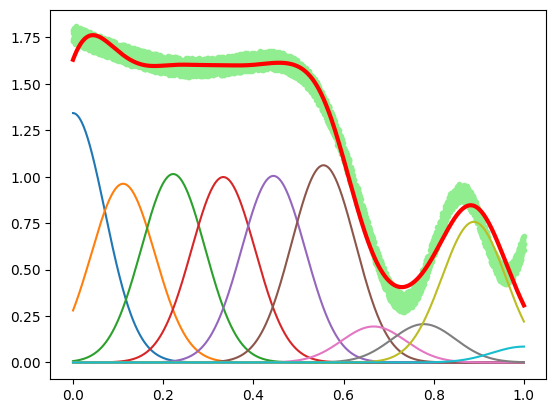

RLS SM theta [1.33600858 0.96573978 1.01069757 0.9978633  1.00734875 1.06191687
 0.18694003 0.22742566 0.73875748 0.11109225]
error :  6.646730227680438
RBFN RLS time: 3.266976504000006


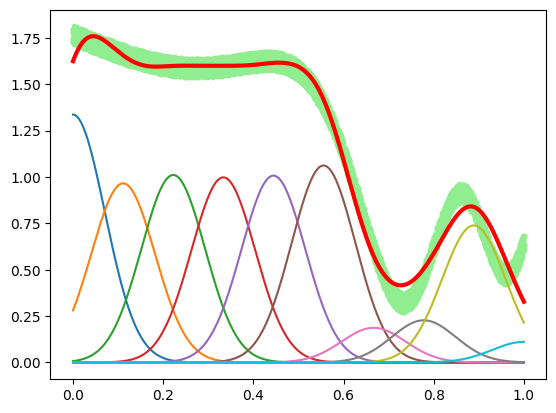

In [25]:
batch = Batch()
max_iter = 5000
model = RLSRBFN(nb_features=10)
start = time.process_time()

for i in range(max_iter):
    x, y = batch.add_non_linear_sample()
    model.train(x, y)

print ("RLS theta", model.theta)
error = model.compute_error(batch.x_data, batch.y_data)
print("error : ", error)
print("RBFN RLS time:", time.process_time() - start)
model.plot(batch.x_data, batch.y_data)

# Need to reinit the model as model.theta must be random again
model = RLSRBFN(nb_features=10)
start = time.process_time()
for i in range(max_iter):
    x, y = batch.add_non_linear_sample()
    model.train_rls_sherman_morrison(x, y)

print ("RLS SM theta", model.theta)
error = model.compute_error(batch.x_data, batch.y_data)
print("error : ", error)
print("RBFN RLS time:", time.process_time() - start)
model.plot(batch.x_data, batch.y_data)

### Study part ###

By varying the number of features, the number of samples and the amount of noise in the data generator, **compare both recursive variants (with and without the Sherman-Morrison formula) and gradient descent. Which is the most precise? The fastest?** Using graphical displays where you are varying the above parameters is strongly encouraged. To change the amount of noise in the generated data, look in the ```sample_generator.py``` file.

### Study part 2 : Incremental versus Batch ###

**Using RBFNs, comment on the main differences between incremental and batch methods. What are their main advantages and disadvantages? Explain how you would choose between an incremental and a batch method, depending on the context.**

# Locally Weighted Regression #


The third family of models is Locally Weighted Least Squares (LWLS).
The LWLS algorithm uses a weighted sum of $M$ local linear models.
In RBFNs, the size of the vector $\boldsymbol{\theta}$ was the number of features.
Here, for each local model $\boldsymbol{\theta}_k$, it is the number of dimensions of $\bar{\bf x}$ to take the intercept into account (remember that $\bar{\bf x} = (x_1 \ x_2 \cdots x_d \ 1)^\intercal$ ; the function to compute $\bar{\bf x}$ is given in ```lwr.py``` under the name ```bar(x)```).
Thus $\dim (\boldsymbol{\theta}_k) = \dim ({\bf x}) +1 = d +1$.
The model of the global latent function can be written

$$
f({\bf x}) = \sum_{k=1}^{M}  \frac{\phi_k({\bf x})}{\sum_{j=1}^{M} \phi_j({\bf x})} m_{\boldsymbol{\theta}_k}({\bf x}),
$$
with $m_{\boldsymbol{\theta}_k}({\bf x}) = \bar{\bf x}^\intercal \boldsymbol{\theta}_k $.

Each local model $\boldsymbol{\theta}_k$ is computed using the following locally weighted error:

$$
\epsilon_k(\boldsymbol{\theta}_k) = \frac{1}{2N}\sum_{i=1}^N \phi_k({\bf x}^{(i)})\left(y^{(i)} - m_{\boldsymbol{\theta}_k}({\bf x}^{(i)})\right)^2$$

$$= \frac{1}{2N}\sum_{i=1}^N \phi_k( {\bf x}^{(i)}) \left(y^{(i)}- (\bar{\bf x}^{(i)})^\intercal \boldsymbol{\theta}_{i} \right)^2.
$$

As with the least squares method, we try to cancel out the gradient, which amounts to solving:

$$
-\frac{1}{N}\sum_{i=1}^N \phi_k({\bf x}^{(i)})\bar{\bf x}^{(i)} \left(y^{(i)} - (\bar{\bf x}^{(i)})^\intercal \boldsymbol{\theta}_k \right) = 0.
$$

Therefore, we pose $\boldsymbol{\theta}_k = A^\sharp_k b_k$, with: 
$$
{\bf A}_k = \sum_{i=1}^N \phi_k({\bf x}^{(i)}) \bar{\bf x}^{(i)} (\bar{\bf x}^{(i)})^\intercal$$
$${\bf b}_k = \sum_{i=1}^N \phi_k({\bf x}^{(i)}) \bar{\bf x}^{(i)} y^{(i)}.$$


This calculation gives us the parameters $\boldsymbol{\theta}_k$ of each local linear model. The global parameter $\boldsymbol{\theta}$ is now a matrix resulting from the concatenation of all local models $\boldsymbol{\theta}_k$.

The function ```bar(x)``` computes $\bar{\bf x} = (x_1 \ x_2 \cdots x_d \ 1)^\intercal$.

The code corresponding to the LWR method is available in the *LWR* class below. 

**In this code, you have to fill the ```train(self, x_data, y_data)``` function**

In [ ]:

def bar(x):
    """
    Add a one at the end of a vector of x data
    :param x: a single vector of size [d]
    :returns: the same vector with a 1 in the end
    """
    if np.size(x) == 1:
        w = np.vstack(([x], [1]))
    else:
        w = np.vstack((x, np.ones((1, np.size(x)))))
    return w


class LWR(Gaussians):
    def __init__(self, nb_features):
        super().__init__(nb_features)
        self.theta = np.zeros((2, self.nb_features))

    def f(self, x):
        """
        Get the FA output for a given input variable(s)

        :param x: a single or vector of dependent variables with size [d] for which to calculate the features

        :returns: a vector of function approximator outputs with size [d]
        """
        wval = bar(x)
        phi = self.phi_output(x)
        linear_model = (np.dot(wval.transpose(), self.theta)).transpose() # [numFeats x d]
        return np.sum(phi * linear_model, axis=0) / np.sum(phi, axis=0)

    def feature(self, x, idx):
        """
         Get the output of the idx^th feature for a given input variable(s)

         :param x: a single or vector of dependent variables with size [d] for which to calculate the features
         :param idx: index of the feature

         :returns: a vector of values
         """
        return np.dot(bar(x)[:, 0], self.theta[:, idx])

    # -- compute the residuals --#
    def compute_error(self, x_data, y_data):
      error = np.linalg.norm(y_data-self.f(x_data))
      return error

    # ----------------------#
    # # Training Algorithm ##
    # ----------------------#

    def train(self, x_data, y_data) -> None:
        """
        Locally weighted least square function
        This code is specific to the 1D case
        :param x_data: a vector of x values
        :param y_data: a vector of y values
        :return: nothing (set the self.theta vector)
        """

        for k in range(self.nb_features):
            a = np.zeros(shape=(2, 2))
            b = np.zeros((2, 1))

            for i in range(len(x_data)):
                w = np.matrix(bar(x_data[i]))
                phi = self.phi_output(x_data[i])[k]
                ww = np.dot(w, w.transpose())

                
                a = ... # Fill this part
                b = ... # Fill this part

            result = np.linalg.pinv(a) * b
            for i in range(2):
                self.theta[i, k] = result[i, 0]


    def plot(self, x_data, y_data):
        xs = np.linspace(0.0, 1.0, 1000)
        z = self.f(xs)

        plt.plot(x_data, y_data, 'o', markersize=3, color='lightgreen')
        plt.plot(xs, z, lw=2, color='red')
        for i in range(self.nb_features):
            ww = (1.0 - 0.0) / self.nb_features / 2.
            xstmp = np.linspace(self.centers[i] - ww, self.centers[i] + ww, 100)

            z2 = []
            for j in xstmp:
                z2.append(self.feature(j, i))
            plt.plot(xstmp, z2, lw=2, color='blue', ls='-')
        plt.show()

Once this is done, you can run the code:

In [ ]:
batch = Batch()
model = LWR(nb_features=10)
batch.make_nonlinear_batch_data()

start = time.process_time()
model.train(batch.x_data, batch.y_data)
print("LWR time:", time.process_time() - start)
model.plot(batch.x_data, batch.y_data)


### Study part ###

**Study the impact of *nb_features* on the accuracy of LWR**. As usual, make a drawing where you measure the residuals as a function of the number of features.

# Regression with Neural Networks (in pytorch) #

In this part we perform regression with neural networks. We are using pytorch. The aim is to show that pytorch does for you a lot of what you have to code when using gradient descent with RBFNs.

In [26]:
%pip install torch

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [27]:
import torch as th
from torch import nn
from torch.nn import functional as func

### Finding the boundaries for output normalization

We will build a neural network whose output is a sigmoid function, thus is constrained in [0,1]. But in our data, y can be in a wider interval. Thus we have to rescale the output of our network. To determine the scope of y, one can use the following code.

In [28]:

my_min = 100
my_max = -100
for i in range(1000000):
  batch = Batch()
  x, y = batch.add_non_linear_sample()
  if y > my_max:
    my_max = y
  if y < my_min:
    my_min = y
print (my_min,my_max)

-1.4640768843299627 2.524700979549276


Then we can write the rescale function.

In [29]:
# the y data is in [-1.5, 2.5], the function below is used to rescale the output of the sigmoid
def rescale(x):
  return 4*x -1.5

Now, we define a neural network model. It has the same ```f()``` function as previous models, and the ```compute_error(x,y)``` function is also the same. But now, the training function just calls ```update(loss)``` and gradient descent is performed using pytorch functions.

In [30]:
class NeuralNetwork(nn.Module):

  def __init__(self, l1, l2, l3, l4, out, learning_rate):
    super(NeuralNetwork, self).__init__()
    self.relu = nn.ReLU()
    self.sigmoid = nn.Sigmoid()
    self.fc1 = nn.Linear(l1, l2)
    self.fc2 = nn.Linear(l2, l3)
    self.fc3 = nn.Linear(l3, l4)
    self.fc4 = nn.Linear(l4, out)
    self.optimizer = th.optim.Adam(self.parameters(), lr=learning_rate)

  def f(self, x):
      input = th.from_numpy(x).float()
      hidden1 = self.sigmoid(self.fc1(input))
      hidden2 = self.sigmoid(self.fc2(hidden1))
      hidden3 = self.sigmoid(self.fc3(hidden2))
      output = rescale(self.sigmoid(self.fc4(hidden3)))
      return output
  
    # -- compute the residuals --#
  def compute_error(self, x_data, y_data):
      error = np.linalg.norm(y_data-self.f(x_data))
      return error

  def update(self, loss) -> None:
      """
      Apply a loss to a network using gradient backpropagation
      :param loss: the applied loss
      :return: nothing
      """
      self.optimizer.zero_grad()
      loss.sum().backward()
      self.optimizer.step()


  def plot(self, x_data, y_data):
    plt.plot(x_data, y_data, 'o', markersize=3, color='lightgreen')
    xs = np.linspace(0.0, 1.0, 1000)
    ys = []
    for x in xs:
      y = self.f(np.array([x])).detach().numpy()
      print (x, y)
      ys.append(y)

    plt.plot(xs, ys, lw=3, color='red')
    plt.show()

### Batch version

We first train the network with a batch of data.

NN Batch Reg time: 178.506138387
0.0 [0.9232073]
0.001001001001001001 [0.92246485]
0.002002002002002002 [0.921716]
0.003003003003003003 [0.9209609]
0.004004004004004004 [0.9201999]
0.005005005005005005 [0.9194324]
0.006006006006006006 [0.918659]
0.007007007007007007 [0.9178796]
0.008008008008008008 [0.917094]
0.009009009009009009 [0.91630244]
0.01001001001001001 [0.91550493]
0.011011011011011011 [0.9147012]
0.012012012012012012 [0.9138918]
0.013013013013013013 [0.91307616]
0.014014014014014014 [0.9122548]
0.015015015015015015 [0.911428]
0.016016016016016016 [0.91059494]
0.017017017017017015 [0.9097564]
0.018018018018018018 [0.90891266]
0.01901901901901902 [0.9080627]
0.02002002002002002 [0.9072075]
0.02102102102102102 [0.90634656]
0.022022022022022022 [0.9054804]
0.023023023023023025 [0.90460896]
0.024024024024024024 [0.90373206]
0.025025025025025023 [0.9028499]
0.026026026026026026 [0.90196276]
0.02702702702702703 [0.9010706]
0.028028028028028028 [0.9001732]
0.029029029029029027 [0.89

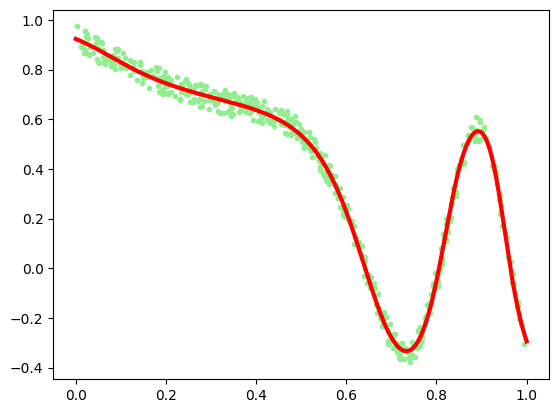

In [31]:
batch = Batch()
size=500
max_iter = 5000
batch.make_nonlinear_batch_data(size)
model = NeuralNetwork(1, 10, 20, 50, 1, 0.05)

start = time.process_time()
x = np.array(batch.x_data)
y = np.array(batch.y_data)

# It is crucial to reshape the x and y vectors
xt = horiz_to_verti(x)
yt = th.from_numpy(horiz_to_verti(y)).float()

for i in range(max_iter):
  output = model.f(xt)
  loss = func.mse_loss(output, yt)
  model.update(loss)
print("NN Batch Reg time:", time.process_time() - start)
model.plot(x, y)


### Incremental version

Then we train the network with one gradient step for each new data point.

NN Reg time: 33.86046645900001
0.0 [1.5383751]
0.001001001001001001 [1.5383751]
0.002002002002002002 [1.5383754]
0.003003003003003003 [1.5383754]
0.004004004004004004 [1.5383754]
0.005005005005005005 [1.5383756]
0.006006006006006006 [1.5383756]
0.007007007007007007 [1.5383756]
0.008008008008008008 [1.5383759]
0.009009009009009009 [1.5383759]
0.01001001001001001 [1.5383759]
0.011011011011011011 [1.5383759]
0.012012012012012012 [1.5383761]
0.013013013013013013 [1.5383766]
0.014014014014014014 [1.5383766]
0.015015015015015015 [1.5383766]
0.016016016016016016 [1.5383766]
0.017017017017017015 [1.5383768]
0.018018018018018018 [1.538377]
0.01901901901901902 [1.538377]
0.02002002002002002 [1.538377]
0.02102102102102102 [1.5383773]
0.022022022022022022 [1.5383773]
0.023023023023023025 [1.5383773]
0.024024024024024024 [1.5383775]
0.025025025025025023 [1.5383775]
0.026026026026026026 [1.5383778]
0.02702702702702703 [1.5383778]
0.028028028028028028 [1.538378]
0.029029029029029027 [1.538378]
0.0300

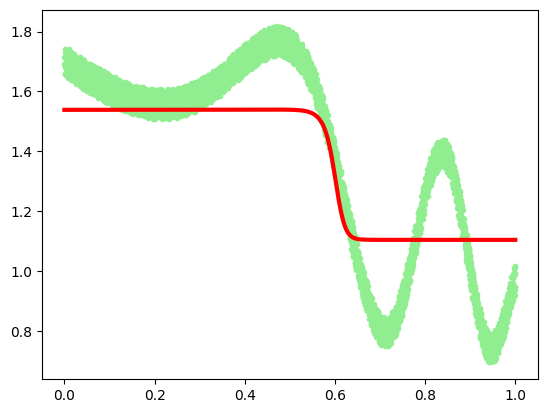

In [33]:
batch = Batch()
max_iter = 5000
model = NeuralNetwork(1, 30, 50, 50, 1, learning_rate=0.05)
start = time.process_time()

for i in range(max_iter):
    x, y = batch.add_non_linear_sample()

    # Note that you have to turn x and y into vectors
    xt = np.array([x])
    yt = th.from_numpy(np.array([y])).float()
    output = model.f(xt)
    # print (x, y, output)
    loss = func.mse_loss(output, yt)
    model.update(loss)
print("NN Reg time:", time.process_time() - start)
#print(batch.x_data, batch.y_data)
model.plot(batch.x_data, batch.y_data)

### Incremental version over a constant batch

Now we do something intermediate: we compute a fixed batch of data, and we sample from it to perform each gradient step.

NN Incr Reg time: 205.45671042299995
0.0 [1.9841571]
0.001001001001001001 [1.9839725]
0.002002002002002002 [1.9837844]
0.003003003003003003 [1.9835923]
0.004004004004004004 [1.9833968]
0.005005005005005005 [1.9831967]
0.006006006006006006 [1.9829931]
0.007007007007007007 [1.9827852]
0.008008008008008008 [1.9825735]
0.009009009009009009 [1.9823573]
0.01001001001001001 [1.982137]
0.011011011011011011 [1.9819121]
0.012012012012012012 [1.981683]
0.013013013013013013 [1.9814491]
0.014014014014014014 [1.9812107]
0.015015015015015015 [1.9809675]
0.016016016016016016 [1.9807198]
0.017017017017017015 [1.9804671]
0.018018018018018018 [1.9802094]
0.01901901901901902 [1.9799466]
0.02002002002002002 [1.9796793]
0.02102102102102102 [1.9794061]
0.022022022022022022 [1.9791284]
0.023023023023023025 [1.9788449]
0.024024024024024024 [1.9785554]
0.025025025025025023 [1.9782612]
0.026026026026026026 [1.9779613]
0.02702702702702703 [1.9776556]
0.028028028028028028 [1.977344]
0.029029029029029027 [1.9770265

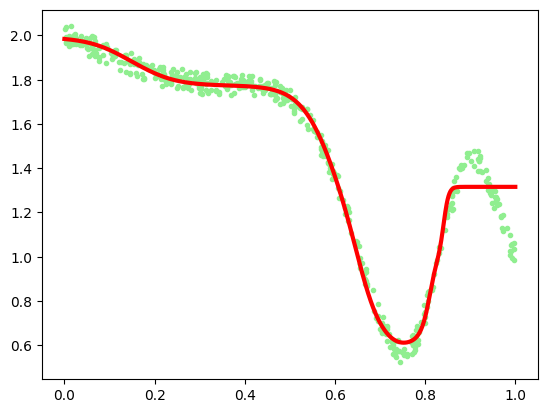

In [34]:
from random import randrange

batch = Batch()
size = 500
batch.make_nonlinear_batch_data(size)


# Note that you need many more steps and a smaller gradient step
max_iter = 30000
model = NeuralNetwork(1, 30, 50, 50, 1, learning_rate=0.015)
start = time.process_time()

for i in range(max_iter):
  index = randrange(size)
  x = batch.x_data[index]
  y = batch.y_data[index]
  xt = np.array([x])
  yt = th.from_numpy(np.array([y])).float()
  output = model.f(xt)
  # print (x, y, output)
  loss = func.mse_loss(output, yt)
  model.update(loss)
print("NN Incr Reg time:", time.process_time() - start)
model.plot(batch.x_data, batch.y_data)

#### Incremental version using minibatches ###

NN Incr Reg time: 111.12647476899997
0.0 [0.05166304]
0.001001001001001001 [0.05142736]
0.002002002002002002 [0.05118895]
0.003003003003003003 [0.05094802]
0.004004004004004004 [0.0507046]
0.005005005005005005 [0.05045855]
0.006006006006006006 [0.05021]
0.007007007007007007 [0.04995883]
0.008008008008008008 [0.04970515]
0.009009009009009009 [0.04944861]
0.01001001001001001 [0.04918969]
0.011011011011011011 [0.0489279]
0.012012012012012012 [0.04866338]
0.013013013013013013 [0.04839611]
0.014014014014014014 [0.04812634]
0.015015015015015015 [0.04785371]
0.016016016016016016 [0.04757833]
0.017017017017017015 [0.04730022]
0.018018018018018018 [0.04701924]
0.01901901901901902 [0.04673553]
0.02002002002002002 [0.04644907]
0.02102102102102102 [0.04615951]
0.022022022022022022 [0.04586732]
0.023023023023023025 [0.04557228]
0.024024024024024024 [0.04527426]
0.025025025025025023 [0.04497337]
0.026026026026026026 [0.04466963]
0.02702702702702703 [0.04436278]
0.028028028028028028 [0.0440532]
0.029

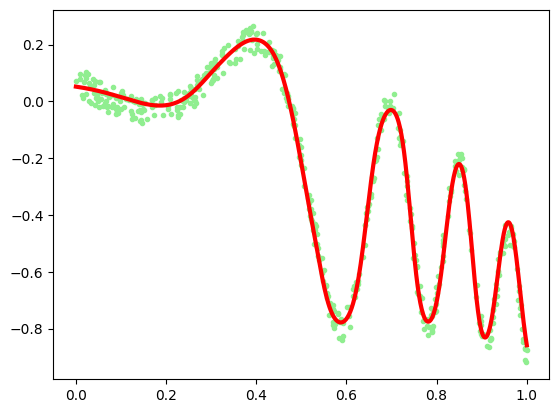

In [35]:
from random import randrange

def make_minibatch(minibatch_size, x_data, y_data, batch_size):
  xm = []
  ym = []
  for i in range(minibatch_size):
    index = randrange(size)
    xm.append([batch.x_data[index]])
    ym.append([batch.y_data[index]])
  return np.array(xm), np.array(ym)

batch = Batch()
size = 500
batch.make_nonlinear_batch_data(size)


max_iter = 5000
minibatch_size = 50
model = NeuralNetwork(1, 30, 50, 50, 1, learning_rate=0.03)
start = time.process_time()

for i in range(max_iter):
  xt, ym = make_minibatch(minibatch_size, batch.x_data, batch.y_data, size)
  yt = th.from_numpy(ym).float()
  output = model.f(xt)
  loss = func.mse_loss(output, yt)
  #print(loss.item(), model.compute_error(xt,yt))
  model.update(loss)
print("NN Incr Reg time:", time.process_time() - start)
model.plot(batch.x_data, batch.y_data)

### Study part

- comment on the difference of results between the batch version, the incremental version and the incremental version with mini-batches
- by measuring the loss function, study the evolution of the final loss and the training time depending on the size of the minibatch, for a constant budget of iterations
- add a training set, a validation set and a test set, and study overfitting